### The codes are used to fit the temerature dependent absorption spectra for the $\sigma$ polarisation (laser polarisation is perpendicular to the crystal axis) using the white light source

In [157]:
import os
from io import StringIO 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy import signal
from scipy.optimize import curve_fit
from scipy.integrate import simpson

Setting up the paths of the raw data

In [158]:
dir = 'C:\\Users\\wj2002\Dropbox (Heriot-Watt University Team)\\2021_HWU\\Exp data-2021'
folder = '20221123_0_1%_PrYVO4_absorption_whitelight'
sub_folders = ['2.7K','90K','120K','150K','210K','248K']
file_name=['OD_013.csv','OD_013.csv','OD_013.csv','OD_013.csv','OD_022.csv','OD_022.csv']

Reading the raw data and save all the raw data in one array

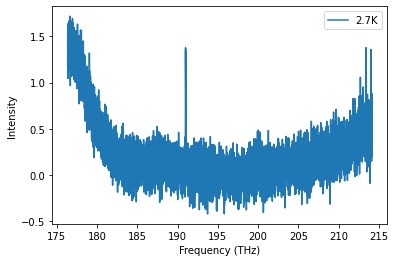

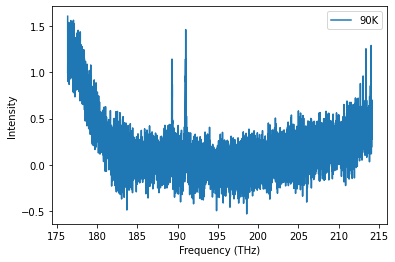

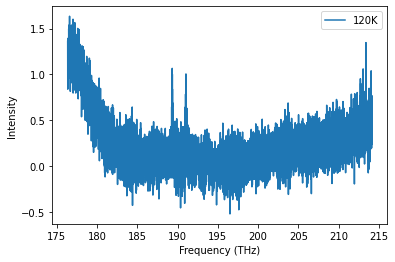

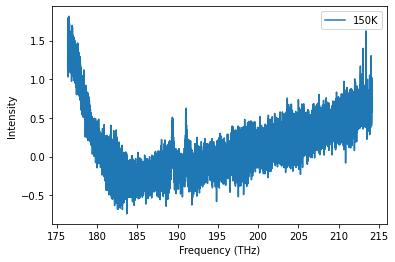

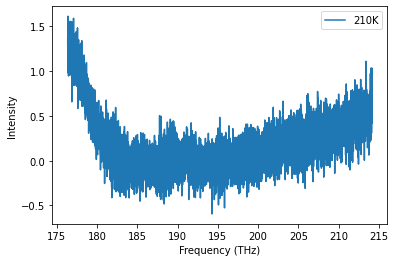

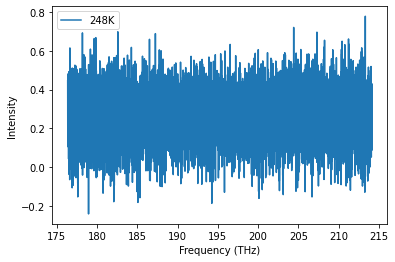

In [159]:
data=[]
data=pd.DataFrame(data)
for index,file in enumerate(file_name):
    path=dir + '\\' + folder + '\\' + sub_folders[index] + '\\'+file

    file_data = open(path, 'r')
    content = file_data.read()
    # change new line character from '\r\n' to '\n'
    lines = content.replace('\r', '').split('\n')
    # Remove the first and last 2 lines of the file
    # StringIO can be considered as a file stored in memory
    read_data=pd.read_csv(StringIO("\n".join(lines[99:-3])), header=None)
    #read_data=read_data.to_numpy() # Read the raw data when the laser is focused into the sample

    data[index*2]=read_data[0]
    data[index*2+1]=read_data[1]

    fig,ax=plt.subplots()
    ax.plot(read_data[0],read_data[1], label="{}".format(sub_folders[index]))
    ax.legend()
    ax.set_xlabel('Frequency (THz)')
    ax.set_ylabel('Intensity')

output_raw_data=data.to_numpy()

1
190.9904379418004
2
189.30919016511444
191.00637781756816
2
189.34879261606605
191.03603769313858
2
189.38396985433033
191.05236118488241
2
189.4820305118911
191.10755962830646


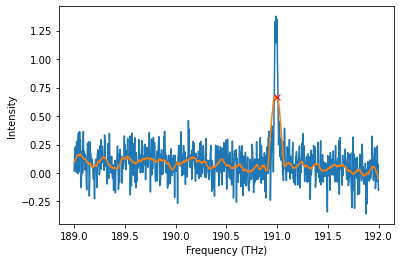

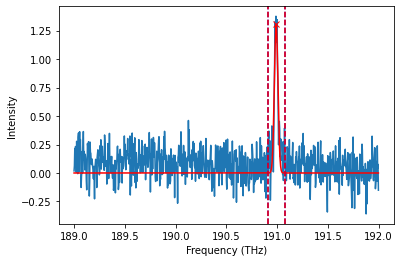

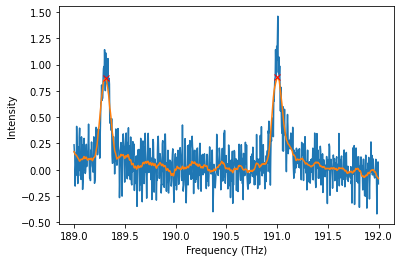

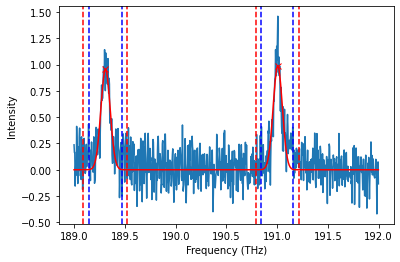

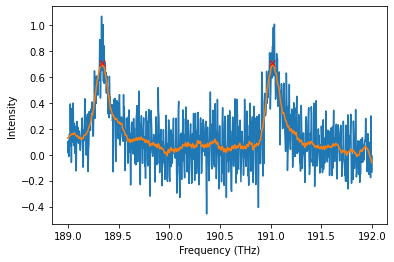

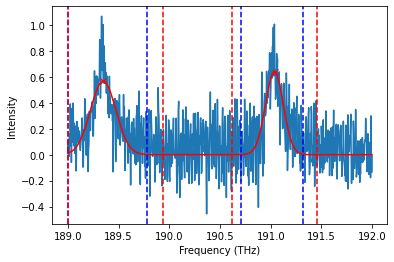

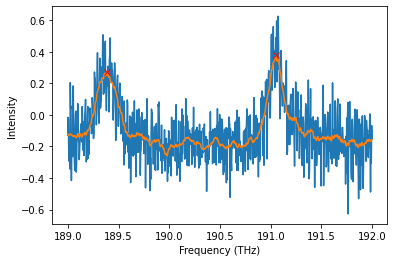

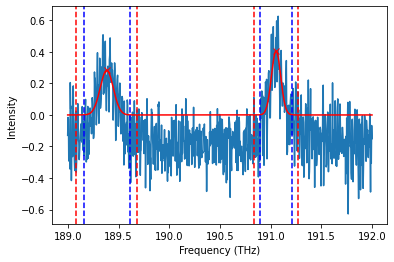

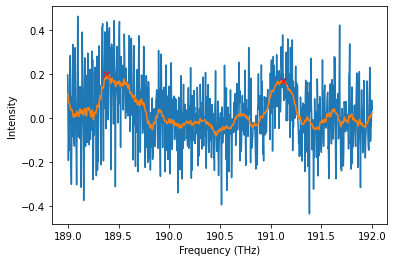

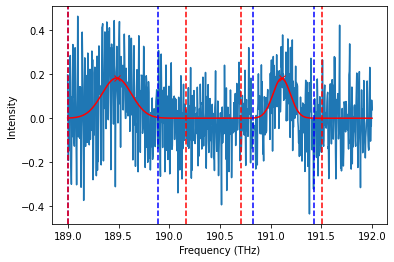

In [174]:
prominence_value=[0.5,0.5,0.4,0.1,0.1]
fitted_data=[]
fitted_data=pd.DataFrame(fitted_data)
fitted_data_normalised=[]
fitted_data_normalised=pd.DataFrame(fitted_data_normalised)

FWHM_0=np.zeros(len(file_name)-1)
f0_0=np.zeros(len(file_name)-1)
FWHM_1=np.zeros(len(file_name)-1)
FWHM_2=np.zeros(len(file_name)-1)
f0_1=np.zeros(len(file_name)-1)
f0_2=np.zeros(len(file_name)-1)

peak_amplitude_0=np.zeros(len(file_name)-1)
peak_amplitude_1=np.zeros(len(file_name)-1)
peak_amplitude_2=np.zeros(len(file_name)-1)

peak_area_0=np.zeros(len(file_name)-1)
peak_area_1=np.zeros(len(file_name)-1)
peak_area_2=np.zeros(len(file_name)-1)

peak_amplitude_fitting_0=np.zeros(len(file_name)-1)
peak_amplitude_fitting_1=np.zeros(len(file_name)-1)
peak_amplitude_fitting_2=np.zeros(len(file_name)-1)

peak_area_fitting_0=np.zeros(len(file_name)-1)
peak_area_fitting_1=np.zeros(len(file_name)-1)
peak_area_fitting_2=np.zeros(len(file_name)-1)

peak_num=np.zeros(len(file_name)-1)

#print(type(f0_2[0]))

def gaussian(x, height, centre, sigma): # Do a Gaussian fitting here of the calculated OD
    '''Generates Gaussian with given parameters'''
    return height * np.exp(-(np.power(x - centre, 2) / (2 * sigma ** 2)))

def bi_gaussian(x, height_1, centre_1, sigma_1, height_2, centre_2, sigma_2):
    return gaussian(x, height_1, centre_1, sigma_1) + gaussian(x, height_2, centre_2, sigma_2)


for index in range(len(file_name)-1):
    freq=data[index*2]
    freq=freq.to_numpy()
    intensity=data[index*2+1]
    intensity=intensity.to_numpy()

    freq_start=189 # Set the starting point to plot the figure
    freq_stop=192  # Set the stoping point to plot the figure
    diff_freq_start=np.absolute(freq-freq_start)
    diff_freq_stop=np.absolute(freq-freq_stop)
    index_start=diff_freq_start.argmin()
    index_stop=diff_freq_stop.argmin()
    
    freq_plot=freq[index_start:index_stop]
    intensity_plot=intensity[index_start:index_stop]
    
    intensity_smooth=signal.savgol_filter(intensity_plot,50,3, mode="nearest")
    peaks,_=signal.find_peaks(intensity_smooth,prominence=prominence_value[index])
    print(len(peaks))
    
    fig,ax=plt.subplots()
    ax.plot(freq_plot,intensity_plot)
    ax.plot(freq_plot,intensity_smooth)
    ax.plot(freq_plot[peaks], intensity_smooth[peaks], "x",color='red')
    ax.set_xlabel('Frequency (THz)')
    ax.set_ylabel('Intensity')
    fig.patch.set_facecolor('white')

    if len(peaks) == 1:
        peak_num[index]=1
        fit_1,success_1=curve_fit(gaussian,freq_plot,intensity_plot,p0=[intensity_plot[peaks[0]],freq_plot[peaks[0]],0.1]) 
        freq_0=np.linspace(min(freq_plot),max(freq_plot),1000)
        fit_curve=gaussian(freq_0,fit_1[0],fit_1[1],fit_1[2])
        normalised_fit_curve = (fit_curve-min(fit_curve))/(max(fit_curve)-min(fit_curve))

        test=2*np.sqrt(2*np.log(2))*abs(fit_1[2])*1000
        FWHM_0[index]=2*np.sqrt(2*np.log(2))*abs(fit_1[2])*1000 # Calculated FWHM based on the Gaussian fitting
        f0_0[index]=fit_1[1]
        print(fit_1[1])
        
        # Find the boundries of the window of raw data for calculating the area of the peak
        area_boundry_left_0=freq_plot[peaks]-FWHM_0[index]*2/1000
        area_boundry_right_0=freq_plot[peaks]+FWHM_0[index]*2/1000
        diff_AB_left_0=np.absolute(freq_plot-area_boundry_left_0)
        diff_AB_right_0=np.absolute(freq_plot-area_boundry_right_0)
        pos_AB_left_0=diff_AB_left_0.argmin()
        pos_AB_right_0=diff_AB_right_0.argmin()
        peak_amplitude_0[index]=max(intensity_plot[pos_AB_left_0:pos_AB_right_0])
        peak_area_0[index]=simpson(intensity_plot[pos_AB_left_0:pos_AB_right_0],freq_plot[pos_AB_left_0:pos_AB_right_0])
        
        # Find the boundries of the window of the fitted data for calculating the area of the peak
        peaks_fitting,_=signal.find_peaks(fit_curve,prominence=prominence_value[index])
        area_boundry_fitting_left_0=freq_0[peaks_fitting]-FWHM_0[index]*2/1000
        area_boundry_fitting_right_0=freq_0[peaks_fitting]+FWHM_0[index]*2/1000
        diff_AB_fitting_left_0=np.absolute(freq_0-area_boundry_fitting_left_0)
        diff_AB_fitting_right_0=np.absolute(freq_0-area_boundry_fitting_right_0)
        pos_AB_fitting_left_0=diff_AB_fitting_left_0.argmin()
        pos_AB_fitting_right_0=diff_AB_fitting_right_0.argmin()
        peak_amplitude_fitting_0[index]=fit_curve[peaks_fitting]
        peak_area_fitting_0[index]=simpson(fit_curve[pos_AB_fitting_left_0:pos_AB_fitting_right_0],freq_0[pos_AB_fitting_left_0:pos_AB_fitting_right_0])

        fitted_data[index*2]=pd.DataFrame(freq_0)
        fitted_data[index*2+1]=pd.DataFrame(fit_curve)
        fitted_data_normalised[index*2]=pd.DataFrame(freq_0)
        fitted_data_normalised[index*2+1]=pd.DataFrame(normalised_fit_curve)
        
        fig,ax = plt.subplots()
        ax.plot(freq_plot, intensity_plot)
        ax.plot(freq_0,fit_curve,color='r')
        ax.set_xlabel('Frequency (THz)')
        ax.set_ylabel('Intensity')
        ax.axvline(freq_plot[pos_AB_left_0],color='b',linestyle='dashed')
        ax.axvline(freq_plot[pos_AB_right_0],color='b',linestyle='dashed')
        ax.plot(freq_0[peaks_fitting], fit_curve[peaks_fitting], "x",color='red')
        ax.axvline(freq_0[pos_AB_fitting_left_0],color='r',linestyle='dashed')
        ax.axvline(freq_0[pos_AB_fitting_right_0],color='r',linestyle='dashed')

    elif len(peaks) == 2:
        peak_num[index]=2
        fit_2,success_2=curve_fit(bi_gaussian,freq_plot,intensity_plot,p0=[intensity_plot[peaks[0]],freq_plot[peaks[0]],0.1,intensity_plot[peaks[1]],freq_plot[peaks[1]],0.1])
        freq_0=np.linspace(min(freq_plot),max(freq_plot),1000)
        fit_curve=bi_gaussian(freq_0,fit_2[0],fit_2[1],fit_2[2],fit_2[3],fit_2[4],fit_2[5])
        normalised_fit_curve = (fit_curve-min(fit_curve))/(max(fit_curve)-min(fit_curve))

        FWHM_1[index]=2*np.sqrt(2*np.log(2))*abs(fit_2[2])*1000 # Calculated FWHM based on the Gaussian fitting
        FWHM_2[index]=2*np.sqrt(2*np.log(2))*abs(fit_2[5])*1000 # Calculated FWHM based on the Gaussian fitting
        f0_1[index] = fit_2[1]
        f0_2[index] = fit_2[4]

        print(fit_2[1])
        print(fit_2[4])

        # Find the boundries of the window of raw data for calculating the area of the peak 1 
        area_boundry_left_1=freq_plot[peaks[0]]-FWHM_1[index]*1.5/1000
        area_boundry_right_1=freq_plot[peaks[0]]+FWHM_1[index]*1.5/1000
        diff_AB_left_1=np.absolute(freq_plot-area_boundry_left_1)
        diff_AB_right_1=np.absolute(freq_plot-area_boundry_right_1)
        pos_AB_left_1=diff_AB_left_1.argmin()
        pos_AB_right_1=diff_AB_right_1.argmin()
        peak_amplitude_1[index]=max(intensity_plot[pos_AB_left_1:pos_AB_right_1])
        peak_area_1[index]=simpson(intensity_plot[pos_AB_left_1:pos_AB_right_1],freq_plot[pos_AB_left_1:pos_AB_right_1])

        # Find the boundries of the window of raw data for calculating the area of the peak 2 
        area_boundry_left_2=freq_plot[peaks[1]]-FWHM_2[index]*1.5/1000
        area_boundry_right_2=freq_plot[peaks[1]]+FWHM_2[index]*1.5/1000
        diff_AB_left_2=np.absolute(freq_plot-area_boundry_left_2)
        diff_AB_right_2=np.absolute(freq_plot-area_boundry_right_2)
        pos_AB_left_2=diff_AB_left_2.argmin()
        pos_AB_right_2=diff_AB_right_2.argmin()
        peak_amplitude_2[index]=max(intensity_plot[pos_AB_left_2:pos_AB_right_2])
        peak_area_2[index]=simpson(intensity_plot[pos_AB_left_2:pos_AB_right_2],freq_plot[pos_AB_left_2:pos_AB_right_2])

        # Find the boundries of the window of the fitted data for calculating the area of the peak 1
        peaks_fitting,_=signal.find_peaks(fit_curve,prominence=prominence_value[index])
        area_boundry_fitting_left_1=freq_0[peaks_fitting[0]]-FWHM_1[index]*2/1000
        area_boundry_fitting_right_1=freq_0[peaks_fitting[0]]+FWHM_1[index]*2/1000
        diff_AB_fitting_left_1=np.absolute(freq_0-area_boundry_fitting_left_1)
        diff_AB_fitting_right_1=np.absolute(freq_0-area_boundry_fitting_right_1)
        pos_AB_fitting_left_1=diff_AB_fitting_left_1.argmin()
        pos_AB_fitting_right_1=diff_AB_fitting_right_1.argmin()
        peak_amplitude_fitting_1[index]=fit_curve[peaks_fitting[0]]
        peak_area_fitting_1[index]=simpson(fit_curve[pos_AB_fitting_left_1:pos_AB_fitting_right_1],freq_0[pos_AB_fitting_left_1:pos_AB_fitting_right_1])
        
        # Find the boundries of the window of the fitted data for calculating the area of the peak 2
        peaks_fitting,_=signal.find_peaks(fit_curve,prominence=prominence_value[index])
        area_boundry_fitting_left_2=freq_0[peaks_fitting[1]]-FWHM_2[index]*2/1000
        area_boundry_fitting_right_2=freq_0[peaks_fitting[1]]+FWHM_2[index]*2/1000
        diff_AB_fitting_left_2=np.absolute(freq_0-area_boundry_fitting_left_2)
        diff_AB_fitting_right_2=np.absolute(freq_0-area_boundry_fitting_right_2)
        pos_AB_fitting_left_2=diff_AB_fitting_left_2.argmin()
        pos_AB_fitting_right_2=diff_AB_fitting_right_2.argmin()
        peak_amplitude_fitting_2[index]=fit_curve[peaks_fitting[1]]
        peak_area_fitting_2[index]=simpson(fit_curve[pos_AB_fitting_left_2:pos_AB_fitting_right_2],freq_0[pos_AB_fitting_left_2:pos_AB_fitting_right_2])
        
        fitted_data[index*2]=pd.DataFrame(freq_0)
        fitted_data[index*2+1]=pd.DataFrame(fit_curve)
        fitted_data_normalised[index*2]=pd.DataFrame(freq_0)
        fitted_data_normalised[index*2+1]=pd.DataFrame(normalised_fit_curve)
        
        fig,ax = plt.subplots()
        ax.plot(freq_plot, intensity_plot)
        ax.plot(freq_0,fit_curve,color='r')
        ax.set_xlabel('Frequency (THz)')
        ax.set_ylabel('Intensity')
        ax.axvline(freq_plot[pos_AB_left_1],color='b',linestyle='dashed')
        ax.axvline(freq_plot[pos_AB_right_1],color='b',linestyle='dashed')
        ax.axvline(freq_plot[pos_AB_left_2],color='b',linestyle='dashed')
        ax.axvline(freq_plot[pos_AB_right_2],color='b',linestyle='dashed')
        ax.plot(freq_0[peaks_fitting], fit_curve[peaks_fitting], "x",color='red')
        ax.axvline(freq_0[pos_AB_fitting_left_1],color='r',linestyle='dashed')
        ax.axvline(freq_0[pos_AB_fitting_right_1],color='r',linestyle='dashed')
        ax.axvline(freq_0[pos_AB_fitting_left_2],color='r',linestyle='dashed')
        ax.axvline(freq_0[pos_AB_fitting_right_2],color='r',linestyle='dashed')
    
    else:
        print('This program can ONLY fit two Gaussian peaks!')

fitted_data=fitted_data.to_numpy()
fitted_data_normalised=fitted_data_normalised.to_numpy()


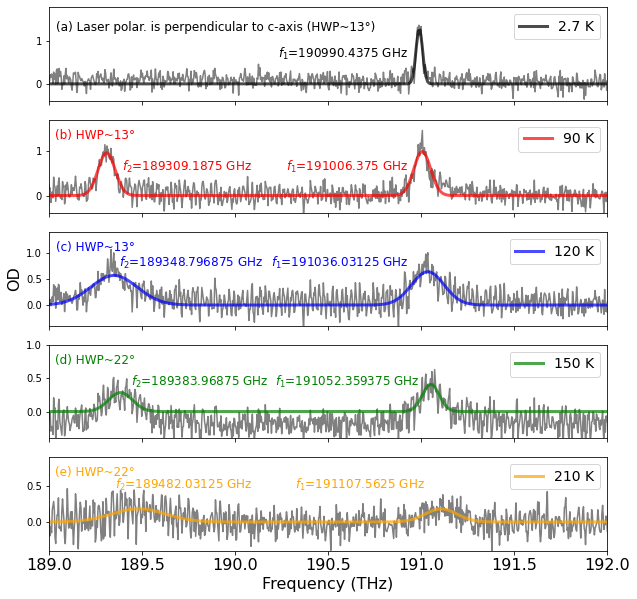

In [146]:
fig,axs=plt.subplots(5,1,figsize=(10,10))

axs[0].plot(output_raw_data[:,0], output_raw_data[:,1], color='grey')
axs[0].plot(fitted_data[:,0], fitted_data[:,1], color='k', label='2.7 K',linewidth=3, alpha=0.7)
axs[0].set_xlim(189,192)
axs[0].set_ylim(-0.4,1.8)
axs[0].set_xticklabels([])

axs[1].plot(output_raw_data[:,2], output_raw_data[:,3], color='grey')
axs[1].plot(fitted_data[:,2], fitted_data[:,3], color='r', label='90 K',linewidth=3 ,alpha=0.7)
axs[1].set_xlim(189,192)
axs[1].set_ylim(-0.4,1.7)
axs[1].set_xticklabels([])

axs[2].plot(output_raw_data[:,4], output_raw_data[:,5], color='grey')
axs[2].plot(fitted_data[:,4], fitted_data[:,5], color='b',linewidth=3, label='120 K',alpha=0.7)
axs[2].set_xlim(189,192)
axs[2].set_ylim(-0.4,1.4)
axs[2].set_xticklabels([])

axs[3].plot(output_raw_data[:,6], output_raw_data[:,7], color='grey')
axs[3].plot(fitted_data[:,6], fitted_data[:,7], color='g',linewidth=3, label='150 K',alpha=0.7)
axs[3].set_xlim(189,192)
axs[3].set_ylim(-0.4,1.0)
axs[3].set_xticklabels([])

axs[4].plot(output_raw_data[:,8], output_raw_data[:,9], color='grey')
axs[4].plot(fitted_data[:,8], fitted_data[:,9], color='orange',linewidth=3, label='210 K',alpha=0.7)
axs[4].set_xlim(189,192)
axs[4].set_ylim(-0.4,0.9)
#axs[4].set_xticklabels(fontsize=18)
plt.xticks(fontsize=16)

axs[0].legend(fontsize=14)
axs[1].legend(fontsize=14)
axs[2].legend(fontsize=14)
axs[3].legend(fontsize=14)
axs[4].legend(fontsize=14)

axs[4].set_xlabel('Frequency (THz)',fontsize=16)
axs[2].set_ylabel('OD',fontsize=16)


axs[0].annotate('(a) Laser polar. is perpendicular to c-axis (HWP~13\N{DEGREE SIGN})',
            xy=(0.62, 0.5), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='k',fontsize=12)

axs[0].annotate(("$f_{1}$"+ "=" +"{} GHz".format(np.float32(f0_0[0]*1000))),
            xy=(0.68, 0.2), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='k',fontsize=12)

axs[1].annotate('(b) HWP~13\N{DEGREE SIGN}',
            xy=(0.19, 0.55), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='r',fontsize=12)

axs[1].annotate(("$f_{2}$"+ "=" +"{} GHz".format(np.float32(f0_1[1]*1000))),
            xy=(0.40, 0.2), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='r',fontsize=12)

axs[1].annotate(("$f_{1}$"+ "=" +"{} GHz".format(np.float32(f0_2[1]*1000))),
            xy=(0.68, 0.2), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='r',fontsize=12)

axs[2].annotate('(c) HWP~13\N{DEGREE SIGN}',
            xy=(0.19, 0.55), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='b',fontsize=12)

axs[2].annotate(("$f_{2}$"+ "=" +"{} GHz".format(np.float32(f0_1[2]*1000))),
            xy=(0.42, 0.37), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='b',fontsize=12)

axs[2].annotate(("$f_{1}$"+ "=" +"{} GHz".format(np.float32(f0_2[2]*1000))),
            xy=(0.68, 0.37), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='b',fontsize=12)

axs[3].annotate('(d) HWP~22\N{DEGREE SIGN}',
            xy=(0.19, 0.55), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='g',fontsize=12)

axs[3].annotate(("$f_{2}$"+ "=" +"{} GHz".format(np.float32(f0_1[3]*1000))),
            xy=(0.43, 0.3), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='g',fontsize=12)

axs[3].annotate(("$f_{1}$"+ "=" +"{} GHz".format(np.float32(f0_2[3]*1000))),
            xy=(0.7, 0.3), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='g',fontsize=12)

axs[4].annotate('(e) HWP~22\N{DEGREE SIGN}',
            xy=(0.19, 0.55), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='orange',fontsize=12)

axs[4].annotate(("$f_{2}$"+ "=" +"{} GHz".format(np.float32(f0_1[4]*1000))),
            xy=(0.4, 0.4), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='orange',fontsize=12)

axs[4].annotate(("$f_{1}$"+ "=" +"{} GHz".format(np.float32(f0_2[4]*1000))),
            xy=(0.71, 0.4), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='orange',fontsize=12)

fig.patch.set_facecolor('white')

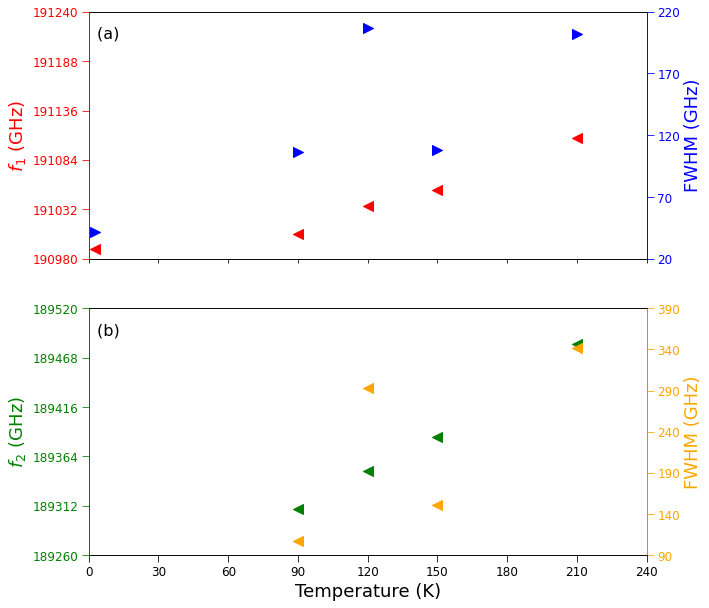

In [224]:
temp=[2.7, 90, 120, 150, 210]
f0_main=np.empty([len(peak_num),2])
FWHM_main=np.empty([len(peak_num),2])
f0_side_1=np.empty([len(peak_num),2])
FWHM_side_1=np.empty([len(peak_num),2])
#Temp_main= np.empty(len(peak_num))
#Tempside_1= np.empty(len(peak_num))

fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(10,10),sharex=True)
ax3 = ax1.twinx()
ax4 = ax2.twinx()

for index in range(len(peak_num)):
    if peak_num[index] == 1:
        f0_main[index,0]=temp[index]
        FWHM_main[index,0]=temp[index]

        f0_main[index,1]=f0_0[index]
        FWHM_main[index,1]=FWHM_0[index]
        
    elif peak_num[index] == 2:
    
        f0_main[index,0]=temp[index]
        FWHM_main[index,0]=temp[index]
        f0_main[index,1]=f0_2[index]
        FWHM_main[index,1]=FWHM_2[index]

        f0_side_1[index,0]=temp[index]
        FWHM_side_1[index,0]=temp[index]
        f0_side_1[index,1]=f0_1[index]
        FWHM_side_1[index,1]=FWHM_1[index]

f0_side_1_new=np.delete(f0_side_1,0,0)
FWHM_side_1_new=np.delete(FWHM_side_1,0,0)

ax1.scatter(f0_main[:,0],f0_main[:,1]*1000,s=100,color='r',marker='<')
ax3.scatter(FWHM_main[:,0],FWHM_main[:,1],s=100,color='b',marker='>')
ax2.scatter(f0_side_1_new[:,0],f0_side_1_new[:,1]*1000,s=100,color='g',marker='<')
ax4.scatter(FWHM_side_1_new[:,0],FWHM_side_1_new[:,1],s=100,color='orange',marker='<')

ax2.set_ylim(189260,189520)
ax2.set_yticks(np.arange(189260,189570,52))
ax4.set_ylim(90,350)
ax4.set_yticks(np.arange(90,400,50))
ax1.set_ylim(190980,191240)
ax1.set_yticks(np.arange(190980,191292,52))
ax3.set_ylim(20,220)
ax3.set_yticks(np.arange(20,270,50))
ax2.set_xlim(0,220)
ax2.set_xticks(np.arange(0,250,30))

ax1.set_ylabel('$f_{1}$ (GHz)',fontsize=18,color='r')
ax1.tick_params(axis='y', colors='red',size=7, labelsize=12)

ax3.set_ylabel('FWHM (GHz)',fontsize=18,color='b')
ax3.tick_params(axis='y', colors='blue',size=7, labelsize=12)

ax3.spines["left"].set_color('red')
ax3.spines["right"].set_color('blue')

ax2.set_xlabel('Temperature (K)',fontsize=18)
ax2.tick_params(axis='x', colors='black',size=7, labelsize=12)

ax2.set_ylabel('$f_{2}$ (GHz)',fontsize=18,color='g')
ax2.tick_params(axis='y', colors='green',size=7, labelsize=12)

ax4.set_ylabel('FWHM (GHz)',fontsize=18,color='orange')
ax4.tick_params(axis='y', colors='orange',size=7, labelsize=12)

ax4.spines["left"].set_color('green')
ax4.spines["right"].set_color('orange')

ax1.annotate('(a) ',
            xy=(0.1, 0.8), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='k',fontsize=16)

ax2.annotate('(b) ',
            xy=(0.1, 0.8), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='k',fontsize=16)

fig.patch.set_facecolor('white')

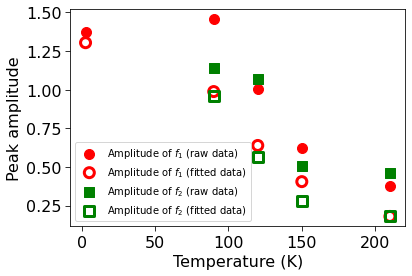

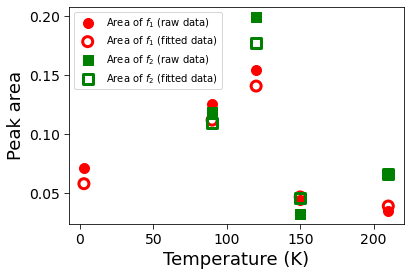

In [231]:
temp=[2.7, 90, 120, 150, 210]

peak_amplitude_main=np.empty([len(peak_num),2])
peak_amplitude_fitting_main=np.empty([len(peak_num),2])
peak_amplitude_side_1=np.empty([len(peak_num),2])
peak_amplitude_fitting_side_1=np.empty([len(peak_num),2])

peak_area_main=np.empty([len(peak_num),2])
peak_area_fitting_main=np.empty([len(peak_num),2])
peak_area_side_1=np.empty([len(peak_num),2])
peak_area_fitting_side_1=np.empty([len(peak_num),2])

for index in range(len(peak_num)):
    if peak_num[index] == 1:
        peak_amplitude_main[index,0]=temp[index]
        peak_amplitude_fitting_main[index,0]=temp[index]
        peak_area_main[index,0]=temp[index]
        peak_area_fitting_main[index,0]=temp[index]

        peak_amplitude_main[index,1]=peak_amplitude_0[index]
        peak_amplitude_fitting_main[index,1]=peak_amplitude_fitting_0[index]
        peak_area_main[index,1]=peak_area_0[index]
        peak_area_fitting_main[index,1]=peak_area_fitting_0[index]
        
    elif peak_num[index] == 2:
        peak_amplitude_main[index,0]=temp[index]
        peak_amplitude_fitting_main[index,0]=temp[index]
        peak_area_main[index,0]=temp[index]
        peak_area_fitting_main[index,0]=temp[index]

        peak_amplitude_main[index,1]=peak_amplitude_2[index]
        peak_amplitude_fitting_main[index,1]=peak_amplitude_fitting_2[index]
        peak_area_main[index,1]=peak_area_2[index]
        peak_area_fitting_main[index,1]=peak_area_fitting_2[index]

        peak_amplitude_side_1[index,0]=temp[index]
        peak_amplitude_fitting_side_1[index,0]=temp[index]
        peak_area_side_1[index,0]=temp[index]
        peak_area_fitting_side_1[index,0]=temp[index]

        peak_amplitude_side_1[index,1]=peak_amplitude_1[index]
        peak_amplitude_fitting_side_1[index,1]=peak_amplitude_fitting_1[index]
        peak_area_side_1[index,1]=peak_area_1[index]
        peak_area_fitting_side_1[index,1]=peak_area_fitting_1[index]

peak_amplitude_side_1_new=np.delete(peak_amplitude_side_1,0,0)
peak_amplitude_fitting_side_1_new=np.delete(peak_amplitude_fitting_side_1,0,0)
peak_area_side_1_new=np.delete(peak_area_side_1,0,0)
peak_area_fitting_side_1_new=np.delete(peak_area_fitting_side_1,0,0)

fig, ax1 = plt.subplots()
ax1.scatter(peak_amplitude_main[:,0],peak_amplitude_main[:,1],color='r',marker='o',s=100,label='Amplitude of $f_{1}$ (raw data)')
ax1.scatter(peak_amplitude_fitting_main[:,0],peak_amplitude_fitting_main[:,1],color='r',marker='o',s=100,facecolors='none', edgecolors='r',linewidths=3,label='Amplitude of $f_{1}$ (fitted data)')
ax1.scatter(peak_amplitude_side_1_new[:,0],peak_amplitude_side_1_new[:,1],color='g',marker='s',s=100,label='Amplitude of $f_{2}$ (raw data)')
ax1.scatter(peak_amplitude_fitting_side_1_new[:,0],peak_amplitude_fitting_side_1_new[:,1],color='g',marker='s',s=100, facecolors='none', edgecolors='g',linewidths=3,label='Amplitude of $f_{2}$ (fitted data)')
ax1.legend()
ax1.set_xlabel('Temperature (K)',fontsize=16)
ax1.set_ylabel('Peak amplitude',fontsize=16)
ax1.tick_params(axis='x',labelsize=16,size=5)
ax1.tick_params(axis='y',labelsize=16,size=5)

fig, ax2 = plt.subplots()
ax2.scatter(peak_area_main[:,0],peak_area_main[:,1],color='r',marker='o',s=100,label='Area of $f_{1}$ (raw data)')
ax2.scatter(peak_area_fitting_main[:,0],peak_area_fitting_main[:,1],color='r',marker='o',s=100,facecolors='none', edgecolors='r',linewidths=3,label='Area of $f_{1}$ (fitted data)')
ax2.scatter(peak_area_side_1_new[:,0],peak_area_side_1_new[:,1],color='g',marker='s',s=100,label='Area of $f_{2}$ (raw data)')
ax2.scatter(peak_area_fitting_side_1_new[:,0],peak_area_fitting_side_1_new[:,1],color='g',marker='s',s=100,facecolors='none', edgecolors='g',linewidths=3,label='Area of $f_{2}$ (fitted data)')
ax2.legend()
ax2.set_xlabel('Temperature (K)',fontsize=18)
ax2.set_ylabel('Peak area',fontsize=18)
ax2.tick_params(axis='x',labelsize=14,size=5)
ax2.tick_params(axis='y',labelsize=14,size=5)

fig.patch.set_facecolor('white')